## PyTorch modules and layers

### What are modules?
Module is an abstraction somewhere between neural network *layer* and complete *model*. In PyTorch, there all kinds of things one can do with modules and their combinations.

![Multiple layers are combined into modules, forming repeating patterns of larger models.](./img/blocks.svg)

From a programming standpoint, a module is represented by a class. Any subclass of it must:
  - define a forward propagation method that transforms its input into output
  - store any necessary parameters.

Start with necessary imports:

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

### Module chaining
We can use a built-in `Sequential` function to chain layers together. The below code creates a hidden layer with 256 neurons and ReLU activation function, and an output layer with 10 neurons:

In [2]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

X = torch.rand(2, 20)
net(X).shape

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 10])

### Forward propagation
**Important**: to use the model, we pass it the input data (`net(X)` in the above example). This executes the model's forward, along with some background operations.

`net(X)` is actually just shorthand for `net.__call__(X)`. `LazyLinear` is a version of `Linear` that *infers* output dimensions.

In [3]:
X.shape

torch.Size([2, 20])

### Create a module from scratch
In the following snippet, we code up a module from scratch corresponding to an MLP with one hidden layer with 256 hidden units, and a 10- dimensional output layer. Note that the MLP class below inherits the class that represents a module. We will heavily rely on the parent class’s methods, supplying only our own constructor (the __init__ method in Python) and the forward propagation method.

In [4]:
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

Let’s first focus on the forward propagation method. Note that it takes X as input, calculates the hidden representation with the activation function applied, and outputs its logits. In this MLP implementation, both layers are instance variables. To see why this is reasonable, imagine instantiating two MLPs, net1 and net2, and training them on different data. Naturally, we would expect them to represent two different learned models.

In [5]:
net = MLP()
net(X).shape

torch.Size([2, 10])

**So**: a module can abstract layers, complete models, or anything in-between.

### Writing your own `Sequential`

We need to define two key methods:

1. A method for appending modules one by one to a list.
2. A forward propagation method for passing an input through the chain of modules, in the same order as they were appended.


In [6]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

Note `add_module` and `children` funcs.

Now we can use it:

In [7]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

### Executing Code in the Forward Propagation Method

The `Sequential` class makes model construction easy,
allowing us to assemble new architectures
without having to define our own class.
However, not all architectures are simple daisy chains.
When greater flexibility is required,
we will want to define our own blocks.
For example, we might want to execute
Python's control flow within the forward propagation method.
Moreover, we might want to perform
arbitrary mathematical operations,
not simply relying on predefined neural network layers.

You may have noticed that until now,
all of the operations in our networks
have acted upon our network's activations
and its parameters.
Sometimes, however, we might want to
incorporate terms
that are neither the result of previous layers
nor updatable parameters.
We call these *constant parameters*.
Say for example that we want a layer
that calculates the function
$f(\mathbf{x},\mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}$,
where $\mathbf{x}$ is the input, $\mathbf{w}$ is our parameter,
and $c$ is some specified constant
that is not updated during optimization.
So we implement a `FixedHiddenMLP` class as follows.

In [8]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In this model,
we implement a hidden layer whose weights
(`self.rand_weight`) are initialized randomly
at instantiation and are thereafter constant.
This weight is not a model parameter
and thus it is never updated by backpropagation.
The network then passes the output of this "fixed" layer
through a fully connected layer.

Note that before returning the output,
our model did something unusual.
We ran a while-loop, testing
on the condition its $\ell_1$ norm is larger than $1$,
and dividing our output vector by $2$
until it satisfied the condition.
Finally, we returned the sum of the entries in `X`.
To our knowledge, no standard neural network
performs this operation.
Note that this particular operation may not be useful
in any real-world task.
Our point is only to show you how to integrate
arbitrary code into the flow of your
neural network computations.

In [9]:
net = FixedHiddenMLP()
net(X)

tensor(-0.2092, grad_fn=<SumBackward0>)

We can mix and match various ways of assembling modules together. In the following example, we nest modules in some creative ways.

In [10]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)

tensor(0.3122, grad_fn=<SumBackward0>)

### Parameters
Once we have chosen an architecture
and set our hyperparameters,
we proceed to the training loop,
where our goal is to find parameter values
that minimize our loss function.
After training, we will need these parameters
in order to make future predictions.
Additionally, we will sometimes wish
to extract the parameters
perhaps to reuse them in some other context,
to save our model to disk so that
it may be executed in other software,
or for examination in the hope of
gaining scientific understanding.

Most of the time, we will be able
to ignore the nitty-gritty details
of how parameters are declared
and manipulated, relying on deep learning frameworks
to do the heavy lifting.
However, when we move away from
stacked architectures with standard layers,
we will sometimes need to get into the weeds
of declaring and manipulating parameters.
In this section, we cover the following:

* Accessing parameters for debugging, diagnostics, and visualizations.
* Sharing parameters across different model components.

Let's use an MLP with one hidden layer:

In [11]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [12]:
X

tensor([[0.4886, 0.6437, 0.0959, 0.0951],
        [0.7799, 0.4169, 0.8617, 0.7937]])

How do we access each layer's parameters? Via indexing.

In [13]:
net[0].state_dict()

OrderedDict([('weight',
              tensor([[-0.4310,  0.1975,  0.0438,  0.4434],
                      [ 0.1986, -0.0764,  0.3607,  0.1213],
                      [ 0.2659, -0.0133, -0.0650, -0.2986],
                      [-0.2179,  0.2317, -0.0690,  0.0202],
                      [-0.0797,  0.4709,  0.0068,  0.3748],
                      [-0.1610,  0.1839, -0.4730,  0.2484],
                      [-0.2718, -0.4398,  0.1086, -0.0794],
                      [-0.0685, -0.4186, -0.3516, -0.0197]])),
             ('bias',
              tensor([ 0.3825, -0.0296,  0.1826, -0.1995, -0.0337, -0.0934,  0.0391,  0.2926]))])

In [14]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.2093, -0.0828, -0.0968,  0.2291,  0.0281, -0.1922,  0.3012, -0.3132]])),
             ('bias', tensor([-0.1151]))])

Note that parameters (weights/bias) are instances of a `torch.nn.parameter.Parameter` class.

In [15]:
net[2].weight

Parameter containing:
tensor([[ 0.2093, -0.0828, -0.0968,  0.2291,  0.0281, -0.1922,  0.3012, -0.3132]],
       requires_grad=True)

We can use `data` field in order to extract actual data:

In [16]:
net[2].weight.data

tensor([[ 0.2093, -0.0828, -0.0968,  0.2291,  0.0281, -0.1922,  0.3012, -0.3132]])

In [17]:
net[2].weight.shape

torch.Size([1, 8])

In [18]:
net[0].weight.shape

torch.Size([8, 4])

We can also access gradients for each layer:

In [19]:
net[2].weight.grad == None

True

We can also access parameters all at once via `nn.Module.named_parameters()`:

In [20]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

We can also tie or connect/share parameters in different layers.

In the following we allocate a fully connected layer
and then use its parameters specifically
to set those of another layer.
Here we need to run the forward propagation
`net(X)` before accessing the parameters.

In [21]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


This example shows that the parameters
of the second and third layer are tied.
They are not just equal, they are
represented by the same exact tensor.
Thus, if we change one of the parameters,
the other one changes, too.

You might wonder,
when parameters are tied
what happens to the gradients?
Since the model parameters contain gradients,
the gradients of the second hidden layer
and the third hidden layer are added together
during backpropagation.



### Initialization

By default, PyTorch initializes weight and bias matrices uniformly by drawing from a range that is computed according to the input and output dimension. PyTorch’s nn.init module provides a variety of preset initialization methods.

Let's start with a sample neural network built with `nn.Sequential`.

In [22]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

### Built-in initializers

This code will initialize weights as Guassian random variables, and biases will be 0. The `apply` method applies the given function recursively to each submodule:

In [23]:
def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0130, -0.0005, -0.0028, -0.0056]), tensor(0.))

Or we can use constants:

In [24]:
def init_constant(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 1)
        nn.init.zeros_(module.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

We can use indexing to initialize parameters for each layer separately:

In [25]:
def init_xavier(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

def init_42(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.6059,  0.1261, -0.4571, -0.0032])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


Sometimes, the initialization methods we need
are not provided by the deep learning framework.
In the example below, we define an initializer
for any weight parameter $w$ using the following strange distribution (here $U$ stands for uniform distribution):

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \textrm{ with probability } \frac{1}{4} \\
            0    & \textrm{ with probability } \frac{1}{2} \\
        U(-10, -5) & \textrm{ with probability } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


In [26]:
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000,  0.0000, -0.0000,  8.7956],
        [-9.3961, -0.0000, -0.0000, -9.5940]], grad_fn=<SliceBackward0>)

And, of course, we can always set the parameters directly:

In [27]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  1.0000,  1.0000,  9.7956])

Or in model class constructor:

In [28]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### Lazy initialization

PyTorch can defer parameter initialization, waiting until the first time we pass data through the model, to infer the sizes of each layer on the fly.

Later on, when working with convolutional neural networks, this technique will become even more convenient since the input dimensionality (e.g., the resolution of an image) will affect the dimensionality of each subsequent layer.

Let's create some perceptron again:

In [29]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

Check first layer params:

In [30]:
net[0].weight

<UninitializedParameter>

We can pass some data:

In [31]:
X = torch.rand(2, 20)
net(X)

net[0].weight.shape

torch.Size([256, 20])

### Custom layers

Let's first try a layer without parameters:

In [32]:
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

Let's see if it works:

In [33]:
layer = CenteredLayer()
layer(torch.tensor([1.0, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

We can use it in some models now:

In [34]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

Check how it works:

In [35]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(7.4506e-09, grad_fn=<MeanBackward0>)

The very small number instead of 0 is due to floating point number arithmetic.

Let's now create a custom layer with parameters: `in_units` and `out_units` for inputs and outputs counts.

In [36]:
class MyLinear(nn.Module):
    def __init__(self, in_units, out_units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, out_units))
        self.bias = nn.Parameter(torch.randn(out_units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

We can instantiate it and check parameters:

In [37]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 2.1138, -0.1511,  0.2780],
        [ 2.6027,  1.3325, -0.0854],
        [-0.2464,  1.1219,  0.3165],
        [-0.6991,  0.0719, -0.3067],
        [ 1.3626, -2.9486, -0.0140]], requires_grad=True)

Now invoke forward propagation using our custom layer:

In [38]:
linear(torch.rand(2, 5))

tensor([[1.3229, 0.0000, 0.8027],
        [3.4442, 0.0000, 0.9920]])

Now we can construct a model using the custom layer:

In [39]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.],
        [0.]])

### Loading and saving

Save a single tensor:

In [40]:
x = torch.arange(4)
torch.save(x, 'torch.data')
x

tensor([0, 1, 2, 3])

Now read it back:

In [41]:
x2 = torch.load('torch.data')
x2

tensor([0, 1, 2, 3])

Same can be done with lists of tensors:

In [42]:
y = torch.zeros(4)
torch.save([x, y],'torch2.data')
x2, y2 = torch.load('torch2.data')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Saving dictionaries of tensors also works:

In [43]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'torch_dict.data')
mydict2 = torch.load('torch_dict.data')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

How does this work for complete models? Let's check it, using the example model for multi-layer perceptron.

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.output = nn.LazyLinear(10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

We can save the parameters of that model with:

In [45]:
torch.save(net.state_dict(), 'mlp.params')

In order to load the model, we can do this:

In [46]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

Let's verify that original model and cloned model produce same results:

In [47]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## Walkthrough with TorchVision dataset

### Fetching data
Let's fetch some sample dataset:

In [48]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). We will use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [49]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [50]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Let's visualize some samples:

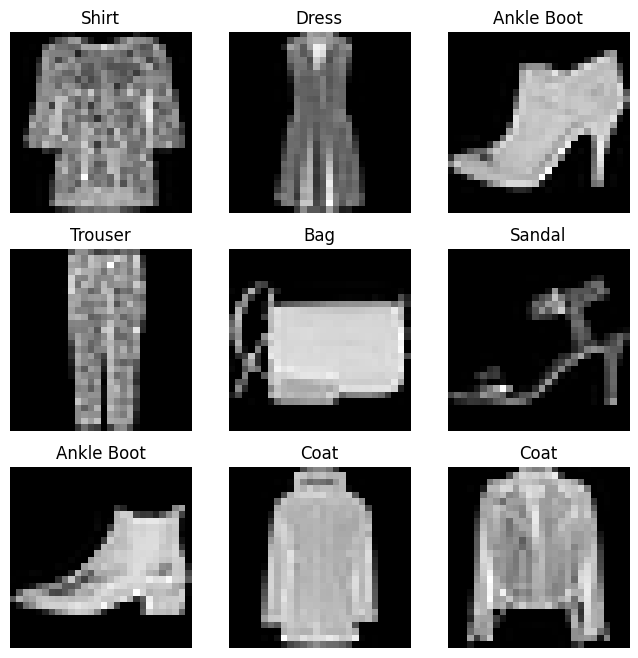

In [51]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Transforms

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we can use ToTensor and Lambda.

`target_transform` defines a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [52]:
%matplotlib inline

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### Defining a network model

Now that we have the test data, define a neural network with 2 hidden layers and ReLU activation functions:

In [53]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Let's break down the steps:
  - initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).
  -  `nn.Linear` is a module that applies a linear transformation on the input using its stored weights and biases.
  -  `nn.ReLU` activations are applied after linear transformations to introduce nonlinearity.
  -  `nn.Sequential` orders the modules.

In order to train a model, we also need to specify a loss function and optimizer:

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Training loop

To sum up, in order to train a model, we need the following:
  - the dataloader that wraps over some dataset
  - model itself (derived from PyTorch's `nn.Module`)
  - loss function
  - optimizer

Needed steps are:
  - compure forward propagation
  - calculate loss
  - compute backward propagation
  - perform GD step

![A picture](./img/training_loop.png)

In [55]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # This just sets the model in train mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We'll also need a test function in order to verify how our model works. Note that we use `torch.no_grad()` as we don't need the gradients when testing:

In [56]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

![A picture](./img/testing_loop.png)

Let's run it:

In [57]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305646  [    0/60000]
loss: 2.287305  [ 6400/60000]
loss: 2.263200  [12800/60000]
loss: 2.257635  [19200/60000]
loss: 2.243382  [25600/60000]
loss: 2.210314  [32000/60000]
loss: 2.225445  [38400/60000]
loss: 2.191915  [44800/60000]
loss: 2.191499  [51200/60000]
loss: 2.149918  [57600/60000]
Test Error: 
 Accuracy: 39.6%, Avg loss: 2.149431 

Epoch 2
-------------------------------
loss: 2.170274  [    0/60000]
loss: 2.154100  [ 6400/60000]
loss: 2.090483  [12800/60000]
loss: 2.104934  [19200/60000]
loss: 2.056350  [25600/60000]
loss: 1.992171  [32000/60000]
loss: 2.025655  [38400/60000]
loss: 1.946812  [44800/60000]
loss: 1.958981  [51200/60000]
loss: 1.869717  [57600/60000]
Test Error: 
 Accuracy: 58.1%, Avg loss: 1.876184 

Epoch 3
-------------------------------
loss: 1.919283  [    0/60000]
loss: 1.884604  [ 6400/60000]
loss: 1.759275  [12800/60000]
loss: 1.794730  [19200/60000]
loss: 1.693333  [25600/60000]
loss: 1.640031  [32000/600

Save and load model:

In [58]:
torch.save(model.state_dict(), "model.pth")
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Let's use the model to make predictions:

In [59]:

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Switch model to evaluation mode
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Homework

In [90]:
# 1. Make a tensor of size (2, 17)
tensor1 = torch.Tensor(2, 17)

# 2. Make a torch.FloatTensor of size (3, 1)
tensor2 = torch.FloatTensor(3, 1)

# 3. Make a torch.LongTensor of size (5, 2, 1) - fill the entire tensor with 7s
tensor3 = torch.LongTensor(5, 2, 1).fill_(7)

#4. Make a torch.ByteTensor of size (5,) - fill the middle 3 indices with ones such that it records [0, 1, 1, 1, 0]
tensor4 = torch.ByteTensor([0,1,1,1,0])

# 5. Perform a matrix multiplication of two tensors of size (2, 4) and (4, 2). Then do it in-place.
tensor5a = torch.Tensor(2,4)
tensor5b = torch.Tensor(4,2)
tensor5 = tensor5a.matmul(tensor5b)

# 6. Do element-wise multiplication of two randomly filled $(n_1,n_2,n_3)$ tensors. Then store the result in an Numpy array.
n1, n2, n3 = 2, 3, 4
tensor6a = torch.randn(n1, n2, n3)
tensor6b = torch.randn(n1, n2, n3)
tensor6 = tensor6a * tensor6b
numpy_result6 = tensor6.numpy()


In [108]:
# 1. Create a Tensor that `requires_grad` of size (5, 5).
tensor = torch.Tensor(5, 5).requires_grad_(True)

# 2. Sum the values in the Tensor.
sum_tensor = torch.sum(tensor)

# 3. Multiply the tensor by 2 and assign the result to a new python variable (i.e. `x = result`)
x = tensor*2

# 4. Sum the variable's elements and assign to a new python variable
sum_x = torch.sum(x)
x.retain_grad()

# 5. Print the gradients of all the variables
print("Gradients before backward pass:")
print("tensor.grad:", tensor.grad)
print("x.grad:", x.grad)

# 6. Now perform a backward pass on the last variable (NOTE: for each new python variable that you define, call `.retain_grad()`)
sum_x.backward()

# 7. Print all gradients again
print("\nGradients after backward pass:")
print("tensor.grad:", tensor.grad)
print("x.grad:", x.grad)

Gradients before backward pass:
tensor.grad: None
x.grad: None

Gradients after backward pass:
tensor.grad: tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]])
x.grad: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


 Use dl_lab2. In Exercise 12 there, you had to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Reimplement the manual code in PyTorch.

In [703]:
from dnn_utilss import load_data
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [704]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)  # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
train_y = train_y.T
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (209, 12288)
test_x's shape: (50, 12288)


In [705]:
class Lab2_reborn(nn.Module):
    def __init__(self, num_layers, p_dropout):
        super(Lab2_reborn, self).__init__()

        self.fc_input = nn.Linear(12288, 50)
        self.fc_intermediate = nn.ModuleList([nn.Linear(50, 50) for i in range(num_layers-2)])
        self.fc_output = nn.Linear(50, 1)

        self.act_relu = nn.ReLU()
        self.act_sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, x):
        x = self.fc_input(x)
        x = self.act_relu(x)
        x = self.dropout(x)

        for layer in self.fc_intermediate:    
            x = layer(x)
            x = self.act_relu(x)
            x = self.dropout(x)

        x = self.fc_output(x)
        x = self.act_sigmoid(x)
        return x


In [726]:
train_loader = torch.utils.data.DataLoader(list(zip(train_x, train_y)), batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(test_x, test_y)), batch_size=256, shuffle=False)

In [727]:
import tqdm
from tqdm.auto import tqdm
def train(model, loader, criterion, optimizer, num_epoch, lambda_reg):
    
    for t in range(num_epoch):
        epoch_loss = []
        for X_batch, y_batch in loader:
            
            X_batch = X_batch.float()
            
            y_pred = model(X_batch)

            # Обчислення втрат з урахуванням регуляризації
            loss = criterion(y_pred, y_batch.float())
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += lambda_reg * l2_reg

            epoch_loss.append(loss.item())
            
            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

        print("curr_loss", np.mean(epoch_loss))

    return model

Compare test accuracy using different optimizers: SGD, Adam, Momentum.

In [741]:
model = Lab2_reborn(4, 0.2)
train(model = model, loader = train_loader, criterion = torch.nn.BCELoss(), optimizer = torch.optim.Adam(model.parameters(), lr=0.00005), num_epoch = 5500, lambda_reg=0.0001)

curr_loss 0.6942524909973145
curr_loss 0.6901870965957642
curr_loss 0.6864171624183655
curr_loss 0.6826123595237732
curr_loss 0.6815986633300781
curr_loss 0.6783754229545593
curr_loss 0.6791033148765564
curr_loss 0.6759153604507446
curr_loss 0.6647382974624634
curr_loss 0.6710578203201294
curr_loss 0.6645553112030029
curr_loss 0.6632770895957947
curr_loss 0.6565704345703125
curr_loss 0.6636834740638733
curr_loss 0.6639242172241211
curr_loss 0.6661004424095154
curr_loss 0.6571187376976013
curr_loss 0.6623221635818481
curr_loss 0.648058295249939
curr_loss 0.6485010981559753
curr_loss 0.663356363773346
curr_loss 0.6655223965644836
curr_loss 0.65651935338974
curr_loss 0.6554093956947327
curr_loss 0.6531057953834534
curr_loss 0.6608253717422485
curr_loss 0.6660369634628296
curr_loss 0.6715925335884094
curr_loss 0.6431719064712524
curr_loss 0.6450334191322327
curr_loss 0.6680038571357727
curr_loss 0.6405676007270813
curr_loss 0.6593456864356995
curr_loss 0.6378479599952698
curr_loss 0.644185

Lab2_reborn(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [742]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])
accuracy = accuracy_score(test_y.T.flatten(), nn_prediction)
accuracy

0.74

In [731]:
model = Lab2_reborn(4, 0)
train(model = model, loader = train_loader, criterion = torch.nn.BCELoss(), optimizer = torch.optim.SGD(model.parameters(), lr=0.05), num_epoch = 3500, lambda_reg=0.0001)

curr_loss 0.6738558411598206
curr_loss 0.6709756851196289
curr_loss 0.6690008640289307
curr_loss 0.6673018932342529
curr_loss 0.6656994819641113
curr_loss 0.6638393402099609
curr_loss 0.6620988845825195
curr_loss 0.6603912115097046
curr_loss 0.6587611436843872
curr_loss 0.6573057770729065
curr_loss 0.6559402346611023
curr_loss 0.6546033024787903
curr_loss 0.653321385383606
curr_loss 0.6522219181060791
curr_loss 0.6512519717216492
curr_loss 0.6502844095230103
curr_loss 0.6495848894119263
curr_loss 0.6486794352531433
curr_loss 0.6480727791786194
curr_loss 0.6474732756614685
curr_loss 0.6471002697944641
curr_loss 0.6462314128875732
curr_loss 0.6456007957458496
curr_loss 0.6451823711395264
curr_loss 0.6447673439979553
curr_loss 0.6447651982307434
curr_loss 0.6437742114067078
curr_loss 0.6434643864631653
curr_loss 0.6433053016662598
curr_loss 0.6425496935844421
curr_loss 0.6422789692878723
curr_loss 0.6420498490333557
curr_loss 0.6413500905036926
curr_loss 0.6408215761184692
curr_loss 0.640

Lab2_reborn(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0, inplace=False)
)

In [732]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])
accuracy = accuracy_score(test_y.T.flatten(), nn_prediction)
accuracy

0.76

In [733]:
model = Lab2_reborn(4, 0)
train(model = model, loader = train_loader, criterion = torch.nn.BCELoss(), optimizer = torch.optim.SGD(model.parameters(), lr=0.005), num_epoch = 3500, lambda_reg=0.001)

curr_loss 0.7123269438743591
curr_loss 0.7112560868263245
curr_loss 0.7102090716362
curr_loss 0.7092821002006531
curr_loss 0.7083800435066223
curr_loss 0.7074599862098694
curr_loss 0.7065311074256897
curr_loss 0.7056445479393005
curr_loss 0.7047526240348816
curr_loss 0.7039210796356201
curr_loss 0.7030749917030334
curr_loss 0.7022621035575867
curr_loss 0.7014776468276978
curr_loss 0.7007139325141907
curr_loss 0.6999561786651611
curr_loss 0.699210524559021
curr_loss 0.6984542012214661
curr_loss 0.6976877450942993
curr_loss 0.6969149112701416
curr_loss 0.6961273550987244
curr_loss 0.6953265070915222
curr_loss 0.6945028901100159
curr_loss 0.6936712265014648
curr_loss 0.692822277545929
curr_loss 0.6919927000999451
curr_loss 0.6911863088607788
curr_loss 0.690385103225708
curr_loss 0.6896031498908997
curr_loss 0.6888225674629211
curr_loss 0.6880542039871216
curr_loss 0.6873013973236084
curr_loss 0.6865577101707458
curr_loss 0.6858158111572266
curr_loss 0.6850769519805908
curr_loss 0.68434655

Lab2_reborn(
  (fc_input): Linear(in_features=12288, out_features=50, bias=True)
  (fc_intermediate): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoid): Sigmoid()
  (dropout): Dropout(p=0, inplace=False)
)

In [734]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(test_x))
    nn_prediction = nn_prediction.tolist()

nn_prediction = np.array([int(x[0] > 0.5) for x in nn_prediction])
accuracy = accuracy_score(test_y.T.flatten(), nn_prediction)
accuracy

0.74